In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('heart.csv')

# One hot encoding categorical data with >2 classes
one_hot_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
oh_encoder = OneHotEncoder()

# Using OrdinalEncoder to encoder categorical data with 2 classes into binary
binary_cols = ['Sex', 'ExerciseAngina']
binary_encoder = OrdinalEncoder()

# Scaling numerical features so logistic regression can converge
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scalar = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ('one_hot', oh_encoder, one_hot_cols),
        ('binary', binary_encoder, binary_cols),
        ('scalar', scalar, numerical_cols)
    ],
    remainder = 'passthrough'
)

# Define features and response var
X = data.drop(columns='HeartDisease')
y = data['HeartDisease']

lbfgs
liblinear
newton-cg
newton-cholesky
sag
saga
[0.8289379900213827, 0.8289379900213827, 0.8289379900213827, 0.8289379900213827, 0.8289379900213827, 0.8289379900213827]


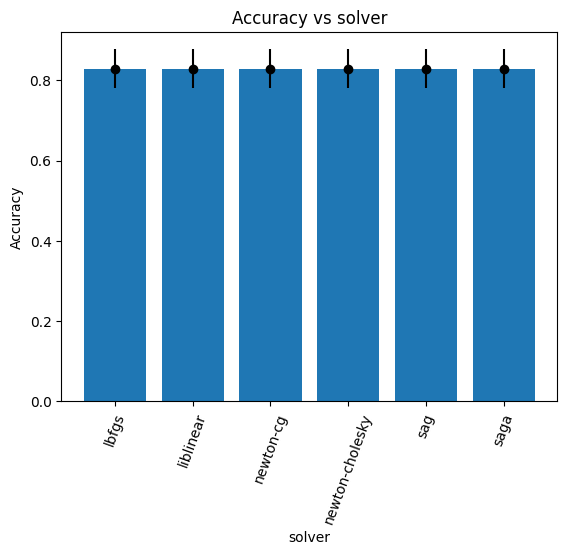

In [2]:
# Cross validation for finding best solver
n_params = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
score_means = []
error = []
for n in n_params:
  print(n)
  lr = Pipeline(
      [
          ("preprocess", preprocessing),
          ("classifier", LogisticRegression(max_iter=1000, solver=n, random_state=0)),
      ]
  )
  cv_scores = cross_val_score(lr, X, y, cv = 5, scoring = 'accuracy')
  score_means.append(np.mean(cv_scores))
  error.append(np.mean(cv_scores) - st.t.interval(0.95, len(cv_scores)-1, loc=np.mean(cv_scores), scale=st.sem(cv_scores))[0])
plt.bar(n_params, score_means)
plt.errorbar(n_params, score_means, yerr = error, fmt='o', color = 'black')
plt.xlabel('solver')
plt.xticks(rotation=70)
plt.ylabel('Accuracy')
plt.title('Accuracy vs solver')
print(score_means)

# All solvers appear to converge to the same solution, likely because of how the data was standardized. lbfgs used

None
l2
[0.8267581373247802, 0.8289379900213827]


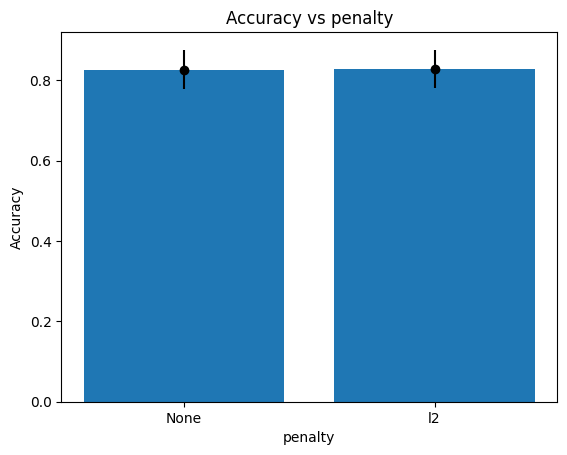

In [3]:
# Cross validation for finding if penalty should be introduced
n_params = [None, 'l2']
score_means = []
error = []
for n in n_params:
  print(n)
  lr = Pipeline(
      [
          ("preprocess", preprocessing),
          ("classifier", LogisticRegression(max_iter=1000, solver='lbfgs', penalty=n, random_state=0)),
      ]
  )
  cv_scores = cross_val_score(lr, X, y, cv = 5, scoring = 'accuracy')
  score_means.append(np.mean(cv_scores))
  error.append(np.mean(cv_scores) - st.t.interval(0.95, len(cv_scores)-1, loc=np.mean(cv_scores), scale=st.sem(cv_scores))[0])
n_params = ['None', 'l2']
plt.bar(n_params, score_means)
plt.errorbar(n_params, score_means, yerr = error, fmt='o', color = 'black')
plt.xlabel('penalty')
plt.ylabel('Accuracy')
plt.title('Accuracy vs penalty')
print(score_means)

# No significant different between penalty terms, l2 (ridge regression) selected because of a slightly higher mean

0.001
0.01
0.1
1
10
[0.7701294844381088, 0.816951770016631, 0.831111903064861, 0.8289379900213827, 0.8267581373247802]


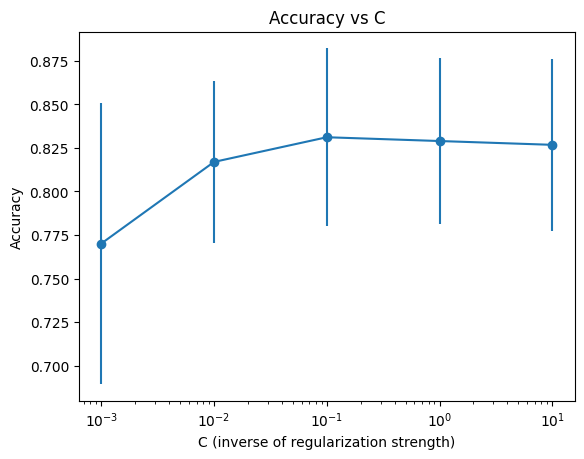

In [4]:
# Cross validation for tuning C parameter (inverse of regularization strength)
n_params = [0.001, 0.01, 0.1, 1, 10]
score_means = []
error = []
for n in n_params:
  print(n)
  lr = Pipeline(
      [
          ("preprocess", preprocessing),
          ("classifier", LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=n, random_state=0)),
      ]
  )
  cv_scores = cross_val_score(lr, X, y, cv = 5, scoring = 'accuracy')
  score_means.append(np.mean(cv_scores))
  error.append(np.mean(cv_scores) - st.t.interval(0.95, len(cv_scores)-1, loc=np.mean(cv_scores), scale=st.sem(cv_scores))[0])
plt.errorbar(n_params, score_means, yerr = error, fmt='o-')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Accuracy vs C')
print(score_means)

# No significant different between values, chose 0.1 because it has the highest mean

Cross Validation Accuracy:
0.8311546840958606
Confusion Matrix:


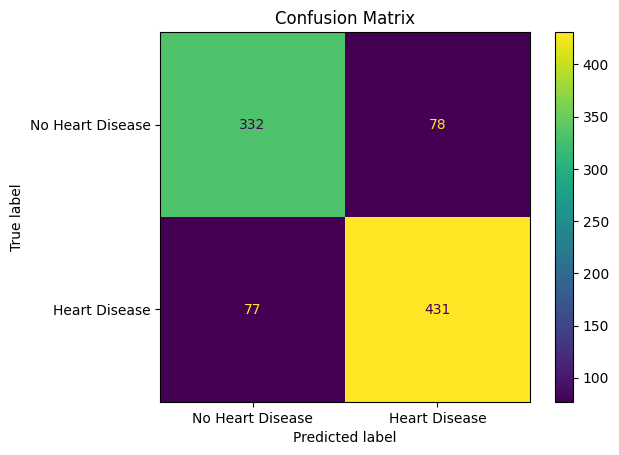

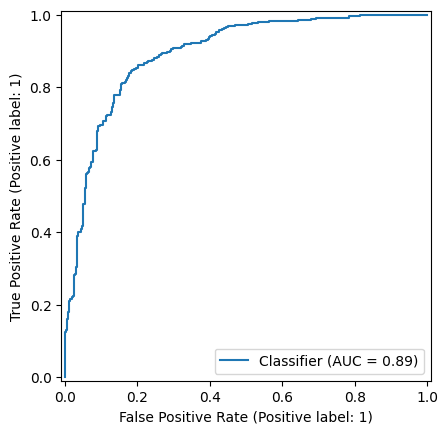

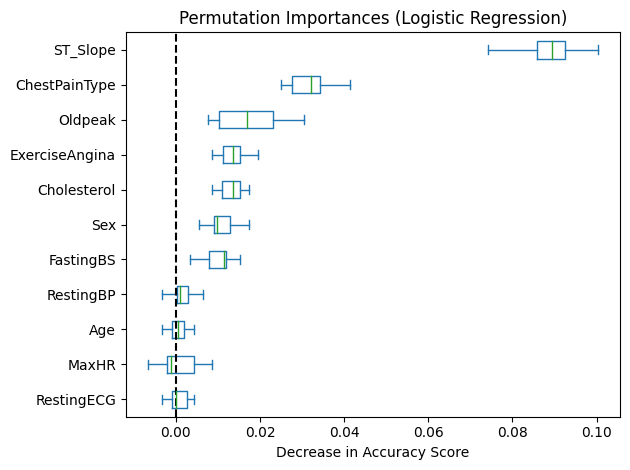

In [5]:
# Logistic regression pipeline
lr = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=0.1, random_state=0)),
    ]
)

# 5-fold Cross validation
y_pred = cross_val_predict(lr, X, y, cv=5)

print('Cross Validation Accuracy:')
print(accuracy_score(y, y_pred))

# print("Classification Report:")
# print(classification_report(y, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['No Heart Disease', 'Heart Disease'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Get ROC curve
y_pred_probs = cross_val_predict(lr, X, y, cv=5, method='predict_proba')[:, 1]
RocCurveDisplay.from_predictions(y, y_pred_probs)
plt.show()

lr.fit(X, y)

result = permutation_importance(lr, X, y, n_repeats=10, random_state=0, n_jobs=-1)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Visualize via boxplot
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (Logistic Regression)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
plt.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.show()
